Plan is simple!
Build a simple AutoEncoder using Pytorch library.
The Image will be from Sklearn inbuilt dataset - LFWPeople


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.datasets import fetch_lfw_people

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
data = fetch_lfw_people(color=True)
X = data.images
y = data.target
X.shape,y.shape

((13233, 62, 47, 3), (13233,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle =True)

In [4]:
#Converting to Images to Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)

# TensorDataset pairs input features (X) with their corresponding labels (y)
# Each item in the dataset is returned as (X[i], y[i])
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [5]:
# Access a single sample from the dataset
# This helps verify the shape of one data sample
first_sample, _ = train_dataset[0]
print(f"Shape of one sample: {first_sample.shape}")

Shape of one sample: torch.Size([62, 47, 3])


In [6]:
# DataLoader for training data
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)
# DataLoader for test/validation data
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)
# Get the first batch from the training DataLoader
X_batch, y_batch = next(iter(train_loader))
print(f"Training batch input shape: {X_batch.shape}")
print(f"Training batch labels shape: {y_batch.shape}")

Training batch input shape: torch.Size([32, 62, 47, 3])
Training batch labels shape: torch.Size([32])


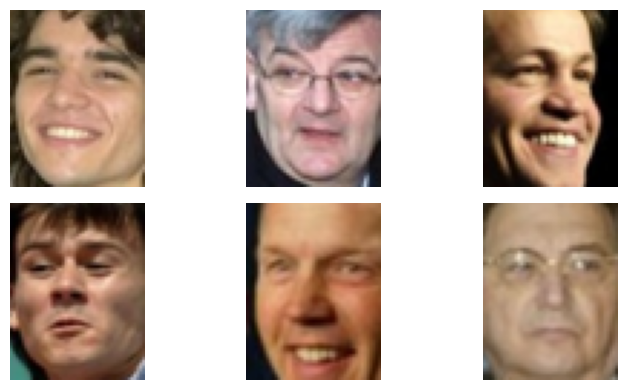

In [7]:
images, labels = next(iter(train_loader))

# Display the first 6 images in the batch
plt.figure(figsize=(8, 4))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze())
    plt.axis('off')

plt.tight_layout()
plt.show()

An Autoencoder is a neural network that learns to:

1. Compress data into a smaller representation (encoding)
2. Reconstruct the original data from that representation (decoding)

###Building a Simple Autoencoder in PyTorch
We'll build a fully-connected autoencoder with:

Input: 8742 (62x47x3 flattened)

Encoder: 8742 → 4096 →2048 →1024 → 512 → 256 (latent code / bottleneck)

Decoder: 256 → 512 → 1024 →2048 → 4096 → 8742

LATENT DIM: 256

X is the input

Z is the latent representation

In [17]:
# Now we are building AutoEncoders using Pytorch
class Autoencoder(nn.Module):

  def __init__(self, latent_dim=256):
    super(Autoencoder, self).__init__()

    # Encoder
    self.encoder = nn.Sequential(
        nn.Linear(8742, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, latent_dim),
        nn.ReLU()
    )

    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,512),
        nn.ReLU(),
        nn.Linear(512,1024),
        nn.ReLU(),
        nn.Linear(1024,2048),
        nn.ReLU(),
        nn.Linear(2048,4096),
        nn.ReLU(),
        nn.Linear(4096,8742),
        nn.Sigmoid()
    )

  def encode(self,x):
    batch_size = x.size(0)
    x = x.view(batch_size,-1) #flattening the X image -> (batch_size, 2914)
    z  = self.encoder(x)
    return z

  def decode(self,z):
    batch_size = z.size(0)
    x_gen = self.decoder(z)
    x_gen = x_gen.view(batch_size,62,47,3)
    return x_gen

  def forward(self,x):
    z = self.encode(x)
    x_gen = self.decode(z)
    return x_gen


In [18]:
LATENT_DIM = 64
model = Autoencoder(latent_dim=LATENT_DIM)

print("Autoencoder Architecture:")
print(model)

Autoencoder Architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=8742, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=64, bias=True)
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=4096, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4096, out_features=8742, bias=True)
    (9): Sigmoid()
  )
)


In [19]:
# Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# MSE Loss for reconstruction
criterion = nn.MSELoss()

# Optimizer
LEARNING_RATE = 0.001
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

NUM_EPOCHS = 10

Using device: cuda


In [20]:
# Training loop
train_losses = []

for epoch in range(NUM_EPOCHS):
  model.train()
  epoch_loss = 0.0

  for X_batch, _ in train_loader:  # We don't need y labels!
    X_batch = X_batch.to(device)

    # Forward pass (forward function)
    X_gen = model(X_batch)

    # Compute loss (compare original vs reconstruction)
    loss = criterion(X_gen, X_batch)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  avg_loss = epoch_loss / len(train_loader)
  train_losses.append(avg_loss)

  print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | Loss: {avg_loss:.6f}")

Epoch [ 1/10] | Loss: 0.025946
Epoch [ 2/10] | Loss: 0.022403
Epoch [ 3/10] | Loss: 0.022260
Epoch [ 4/10] | Loss: 0.022186
Epoch [ 5/10] | Loss: 0.022254
Epoch [ 6/10] | Loss: 0.022227
Epoch [ 7/10] | Loss: 0.022198
Epoch [ 8/10] | Loss: 0.022209
Epoch [ 9/10] | Loss: 0.022174
Epoch [10/10] | Loss: 0.022159


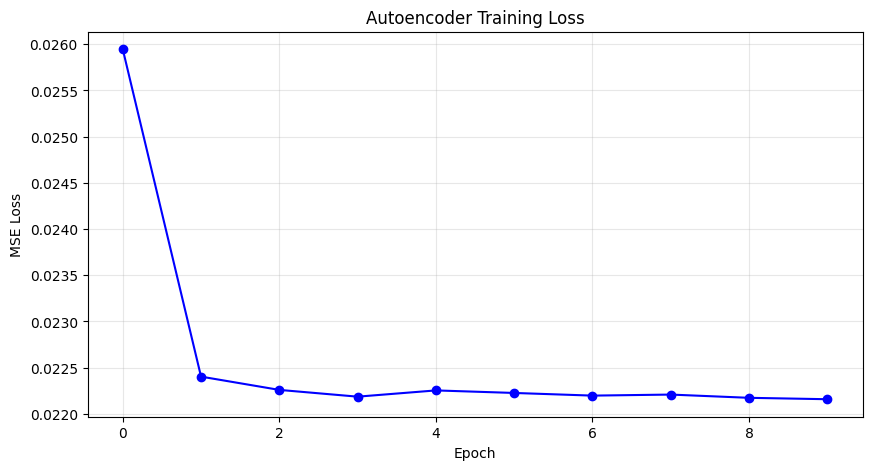

In [21]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

###Visualizing Reconstructions
Let's see how well the autoencoder reconstructs the input images!

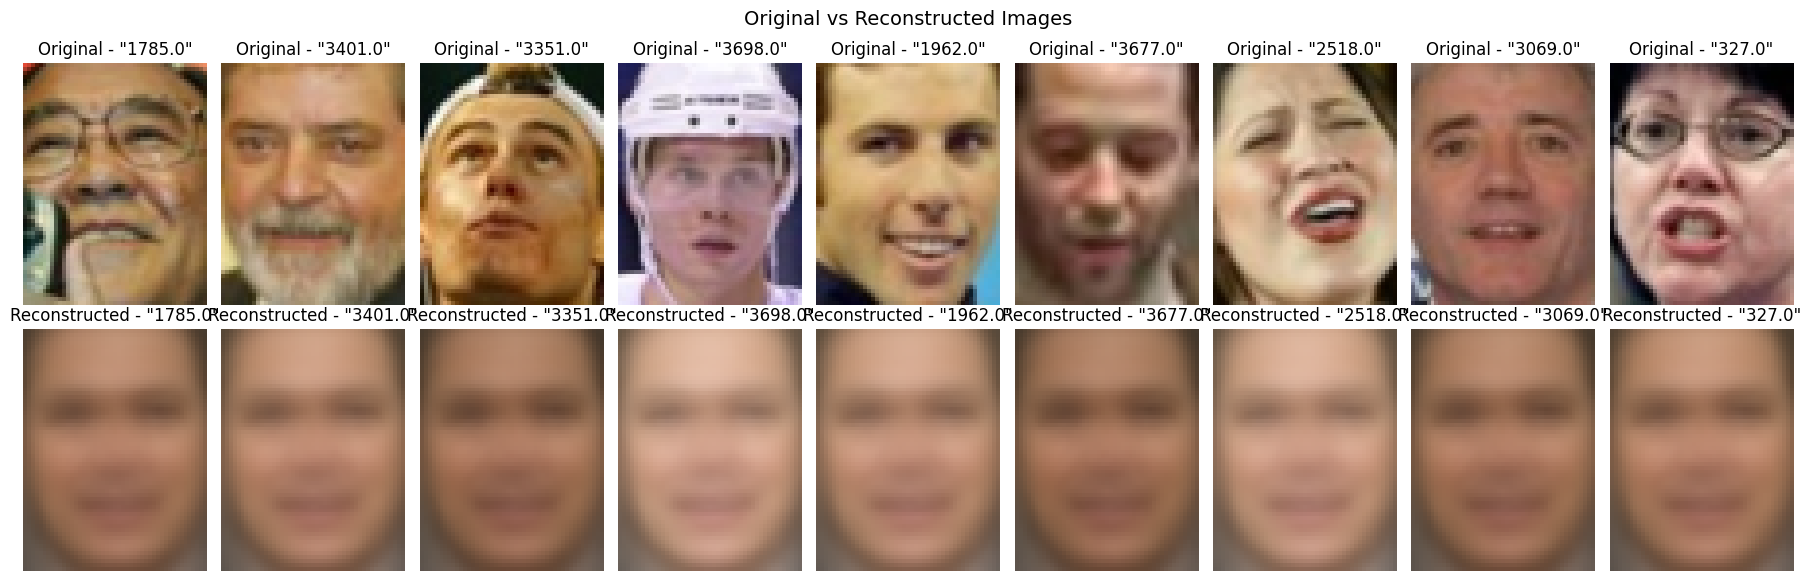

In [24]:
# Get some test images
model.eval()

test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)

with torch.no_grad():
  reconstructed = model(test_images)

# Move to CPU for plotting
test_images = test_images.cpu()
reconstructed = reconstructed.cpu()

# Plot original vs reconstructed
n_images = 9
fig, axes = plt.subplots(2, n_images, figsize=(18, 6))

for i in range(n_images):
  # Original
  axes[0, i].imshow(test_images[i].squeeze())
  axes[0, i].axis('off')
  axes[0, i].set_title(f'Original - "{test_labels[i]}"', fontsize=12)

  # Reconstructed
  axes[1, i].imshow(reconstructed[i].squeeze())
  axes[1, i].axis('off')
  axes[1, i].set_title(f'Reconstructed - "{test_labels[i]}"', fontsize=12)

plt.suptitle('Original vs Reconstructed Images', fontsize=14)
plt.tight_layout()
plt.show()

Better Alternatives to improve Generation:
- Convolutional AutoEncoders
- Variational AutoEncoders
maybe next time :)